# Homework 4 : Model Selection

The goal of this homework is find a suitable model that can distinguish handwritten digits.

In [19]:
import random
import torchvision
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import sklearn

def prepareData(n=1000):
    """
    Downloads the dataset. Displays some examples.
    Returns the labeled dataset.

    Parameters
    ----------
    n : number of data sample (max 70 000)

    Returns
    -------
    X : Data Matrix
        (n, 28, 28).
    y : labels
        n

    """
    mnist_train = torchvision.datasets.MNIST("./data", download=True,)
    mnist_test = torchvision.datasets.MNIST("./data", download=True, train = False)
    

    
    X = []
    y = []
    for x,label in mnist_train:
        X.append(np.array(x))
        y.append(label)
    
    X_test = []
    y_test = []
    for x,label in mnist_test:
        X_test.append(np.array(x))
        y_test.append(label)
    
    X = np.array(X)
    y = np.array(y)
    X_test= np.array(X_test)
    y_test = np.array(y_test)
    
    
    sample = random.sample(range(len(X)), n)
    X = np.concatenate((X,X_test))[sample]
    y = np.concatenate((y,y_test))[sample]
    
    
    return X,y

def showSamples(X,y):
    fig=plt.figure(figsize=(8, 5))
    columns = 5
    rows = 2
    imgs = [X[i,:,:] for i in range(10)]
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(X[i-1,:,:] , cmap ="gray")
        plt.axis('off')
        plt.title(str(y[i-1]))
    plt.show()

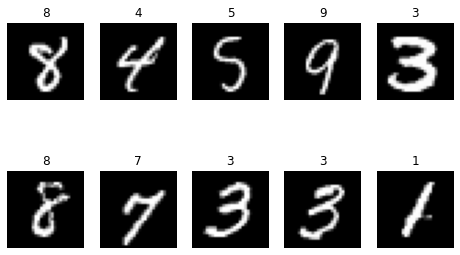

Shape of data matrix X: (1000, 28, 28)
Shape of labels y: (1000,)


In [20]:
X,y = prepareData(1000)
showSamples(X,y)
print("Shape of data matrix X:", X.shape)
print("Shape of labels y:", y.shape)

# Extract features and Train Model

TODO:
- Use any feature extraction method. Compute edges, histogram of oriented gradients, contours etc. to get a more concise representation of the images. 
- Train different models to learn a classification. 
 - You can use any classification model. However, it is easier to use the models from sklearn: https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html
 

In [54]:
from skimage import filters

def featureExtraction(x):
    """
    Detects edges on a singular image.

    Parameters
    ----------
    x : ndarray
        a numpy array of shape 28x28

    Returns
    -------
    ndarray
        The resulting feature should be one-dimensional (use x.flatten())
    """
    #TODO: Define a feauture extraction method. 
    # This method is called individually on each data point. 
    # You can also look into methods that do feature extraction on the complete dataset.
    return x.flatten()

def edges(x):
    """
    Detects edges on a singular image.

    Parameters
    ----------
    x : ndarray
        a numpy array of shape 28x28

    Returns
    -------
    ndarray
        The resulting feature should be one-dimensional (use x.flatten())
    """
    #TODO: Define a feauture extraction method. 
    # This method is called individually on each data point. 
    # You can also look into methods that do feature extraction on the complete dataset.
    return filters.sobel(x).flatten()

from skimage.feature import hog
def hog_feature(x):
    """
    Computes histogram of oriented gradients on a singular image.

    Parameters
    ----------
    x : ndarray
        a numpy array of shape 28x28

    Returns
    -------
    ndarray
        The resulting feature should be one-dimensional (use x.flatten())
    """
    #TODO: Define a feauture extraction method. 
    # This method is called individually on each data point. 
    # You can also look into methods that do feature extraction on the complete dataset.
    _, hog_image = hog(x, orientations=8, pixels_per_cell=(4, 4),
                    cells_per_block=(3, 3), visualize=True)
    return hog_image.flatten()

def preprocessDataset(X, featureExtraction):
    """
    Applies a feature extraction on a dataset

    Parameters
    ----------
    X : ndarray
        Data matrix of size nx28x28
    Returns
    -------
    X_prep : ndarray
        Data matrix of size nxd where d is some dimension of the feature
    """
    
    # TODO: (Optional) You can change this if necessary
    X_prep = []
    for i in range(len(X)):
        x = X[i,:,:]
        x = featureExtraction(x)
        X_prep.append(x)    
    X_prep = np.array(X_prep)
    return X_prep


def train_bayes(X,y):
    # TODO: Select a classifier from sklearn and train it on the data
    from sklearn.naive_bayes import GaussianNB
    model = GaussianNB()
    model.fit(X,y)
    return model

def train_neural(X,y):
    # TODO: Select a classifier from sklearn and train it on the data
    from sklearn.neural_network import MLPClassifier
    model = MLPClassifier()
    model.fit(X,y)
    return model

# K-fold Cross Validation

TODO:
- Implement K-Fold Cross Validation
 - Split data into k partitions
 - Train model on k-1 partitions
 - Evaluate model on remaining partition using **Accuracy** as a metric
 - repeat k-times and compute **average Accuracy** over all splits
 
The following code computes cross-validation on a single data split.
Adjust the code to evaluate on multiple splits.

In [55]:
# Number of data samples (reduce number during initial test runs if procedure takes too long)
n = 50000
X,y = prepareData(n)

# Feature extraction
D_null = preprocessDataset(X, featureExtraction)
D_edge = preprocessDataset(X, edges)
D_hog = preprocessDataset(X, hog_feature)

def k_fold_cross_validation(D: np.ndarray, y: np.ndarray, n_splits: int=5, classifier: str="neural") -> tuple:
    accu_training = 0.0
    accu_test = 0.0
    split_size = len(D)//n_splits
    for i in range(1, n_splits+1):
        X_train = np.concatenate((D[:(n_splits - i)*split_size], D[(n_splits + 1 - i)*split_size:]), axis=0)
        X_test = D[(n_splits - i)*split_size:(n_splits + 1 - i)*split_size]
        y_train = np.concatenate((y[:(n_splits - i)*split_size], y[(n_splits + 1 - i)*split_size:]), axis=0)
        y_test = y[(n_splits - i)*split_size:(n_splits + 1 - i)*split_size]

        # Train model
        if classifier == "bayes":
            model = train_bayes(X_train,y_train)
        elif classifier == "neural":
            model = train_neural(X_train, y_train)

        # Evaluate model on unseen data
        y_pred = model.predict(X_test)
        y_pred_train = model.predict(X_train)
    
        # scores
        accu_training += accuracy_score(y_train,y_pred_train)
        accu_test += accuracy_score(y_test,y_pred)
    return accu_training/n_splits, accu_test/n_splits

#train with neural classifier
acc_train_null_neural, acc_test_null_neural = k_fold_cross_validation(D_null,y,5)
acc_train_edge_neural, acc_test_edge_neural = k_fold_cross_validation(D_edge,y,5)
acc_train_hog_neural, acc_test_hog_neural = k_fold_cross_validation(D_hog,y,5)
print("Accuracy training (k-fold cross validated)(neural classifier): null: ", acc_train_null_neural , " edge: ", acc_train_edge_neural, " hog: ", acc_train_hog_neural)
print("Accuracy test (k-fold cross validated)(neural classifier): null: ", acc_test_null_neural , " edge: ", acc_test_edge_neural, " hog: ", acc_test_hog_neural)
#train with bayesian classifier
acc_train_null_bayes, acc_test_null_bayes = k_fold_cross_validation(D_null,y,5, classifier="bayes")
acc_train_edge_bayes, acc_test_edge_bayes = k_fold_cross_validation(D_edge,y,5,classifier="bayes")
acc_train_hog_bayes, acc_test_hog_bayes = k_fold_cross_validation(D_hog,y,5,classifier="bayes")
print("Accuracy training (k-fold cross validated)(bayesian classifier): null: ", acc_train_null_bayes , " edge: ", acc_train_edge_bayes, " hog: ", acc_train_hog_bayes)
print("Accuracy test (k-fold cross validated)(bayesian classifier): null: ", acc_test_null_bayes , " edge: ", acc_test_edge_bayes, " hog: ", acc_test_hog_bayes)



Accuracy training (k-fold cross validated)(neural classifier): null:  0.9941000000000001  edge:  1.0  hog:  0.995205
Accuracy test (k-fold cross validated)(neural classifier): null:  0.96054  edge:  0.9569000000000001  hog:  0.96804
Accuracy training (k-fold cross validated)(bayesian classifier): null:  0.9943199999999999  edge:  1.0  hog:  0.994815
Accuracy test (k-fold cross validated)(bayesian classifier): null:  0.9607800000000001  edge:  0.95726  hog:  0.9666399999999999


# Document your model selection

TODO:
- Repeat the previous steps, adjust your feature extraction and classification methods until you get satisfying accuracy results.
- Document your experiments. 
- **Tip:** Adjust the previous code, such that you can run multiple experiments, e.g. run different combinations of feature extractors and classifiers.